<a href="https://colab.research.google.com/github/Rhayem1920/Yield-Curve-Prediction/blob/main/Yield_Curve_Predictionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yield curve prediction**

The goal of this case study is to use supervised learning-based models to predict the yield curve. 


## **Problem Definition**

In the supervised regression framework used for this case study, three tenors (i.e. 1M, 5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short term, medium term and long-term tenors of the yield curve.
Features

In order to make predictions, we use the following features:

1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year

2. Changes in % of Federal Debt held by -

    a. Public,       
    b. Foreign Goverments        
    c. Federal Reserve

3. The Coporate Spread on Baa rated Debt Relative to the 10 Year



In [26]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
# rectifying visualistaion's parameters to have pretty plots
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('lines',linewidth=5,c='black')
plt.rcParams["figure.figsize"] = (16,9)
sns.set_style('darkgrid')



In [27]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

dataset.head()



,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2017-04-01,0.77,1.92,3.00,0.74,0.76,1.03,1.27,1.93,2.22,2.40,3.02,0.124,0.724,0.31,2.24
2017-04-07,0.76,1.79,2.92,0.77,0.82,1.08,1.29,1.92,2.20,2.38,3.00,0.124,0.724,0.31,2.24
2017-04-17,0.74,1.81,2.93,0.76,0.83,1.04,1.21,1.79,2.07,2.26,2.92,0.124,0.724,0.31,2.29
2017-04-24,0.67,1.84,3.00,0.74,0.81,1.03,1.25,1.81,2.09,2.28,2.93,0.124,0.724,0.31,2.28
2017-05-01,0.73,1.91,3.02,0.67,0.83,1.09,1.28,1.84,2.13,2.33,3.00,0.124,0.724,0.31,2.29


## **Exploratory Data Analysis**




In [28]:
print('dataset shape is ',(dataset.shape))
pd.set_option('precision', 3)
dataset.describe()

dataset shape is  (247, 15)


,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000,247.000
mean,1.039,1.590,2.403,1.042,1.091,1.218,1.312,1.590,1.777,1.921,2.406,0.133,0.752,0.284,2.168
std,0.899,0.864,0.607,0.897,0.911,0.956,0.948,0.864,0.805,0.756,0.608,0.035,0.024,0.019,0.401
min,0.000,0.220,1.180,0.000,0.000,0.040,0.110,0.220,0.400,0.560,1.180,0.091,0.723,0.250,1.590
25%,0.080,0.805,1.935,0.080,0.095,0.140,0.210,0.805,1.170,1.395,1.935,0.103,0.732,0.266,1.910
50%,1.000,1.690,2.350,1.000,1.070,1.270,1.410,1.690,1.820,1.900,2.350,0.120,0.741,0.294,2.110
75%,1.865,2.335,2.960,1.865,1.945,2.080,2.240,2.335,2.435,2.540,2.960,0.166,0.781,0.301,2.265
max,2.510,3.090,3.430,2.510,2.490,2.740,2.980,3.090,3.170,3.240,3.430,0.202,0.785,0.311,4.130


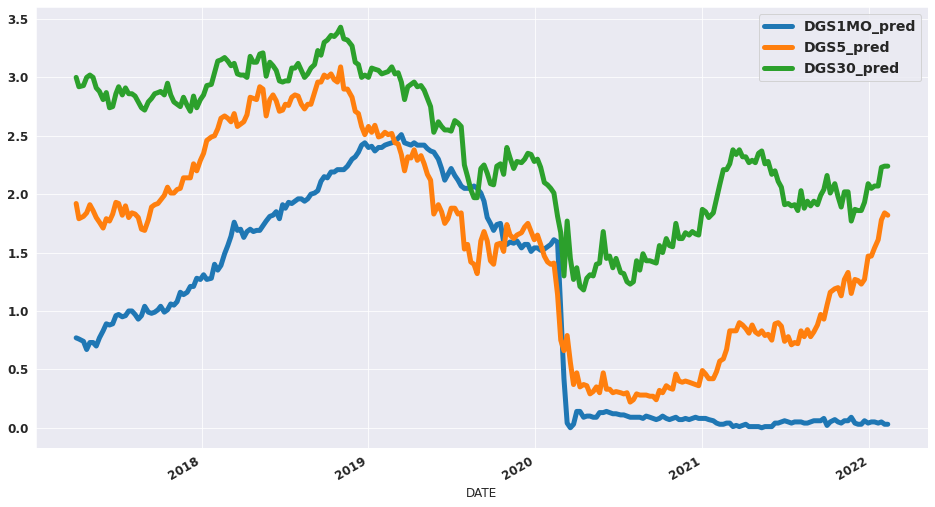

In [29]:
Y.plot()

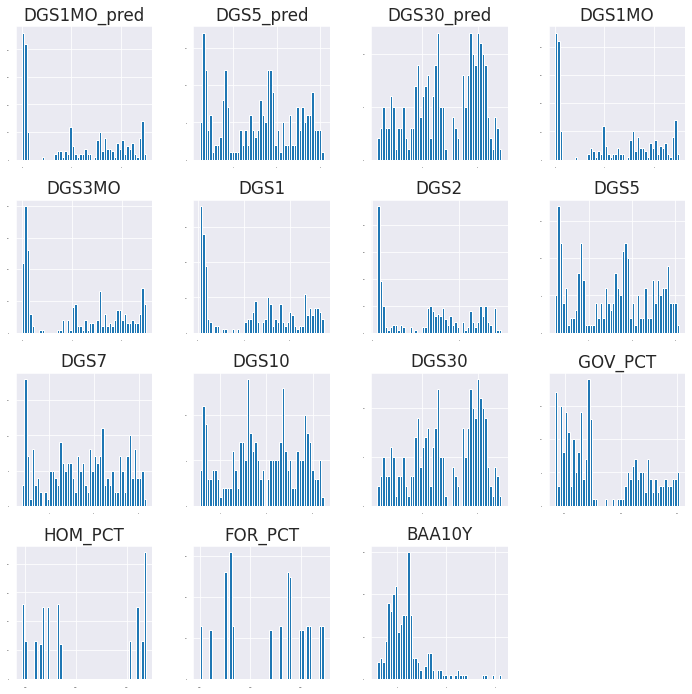

In [30]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12),bins=50)
pyplot.show()

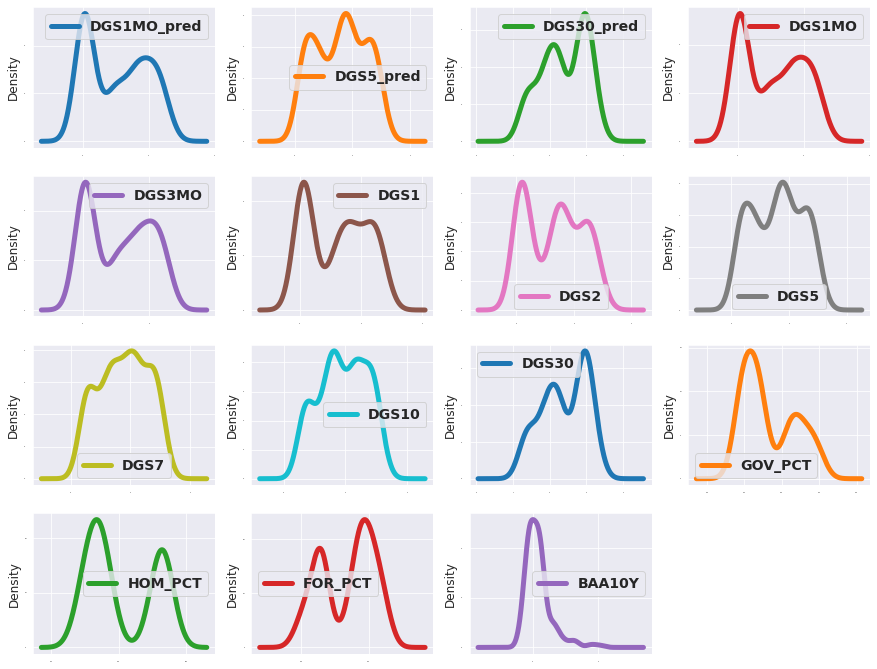

In [31]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

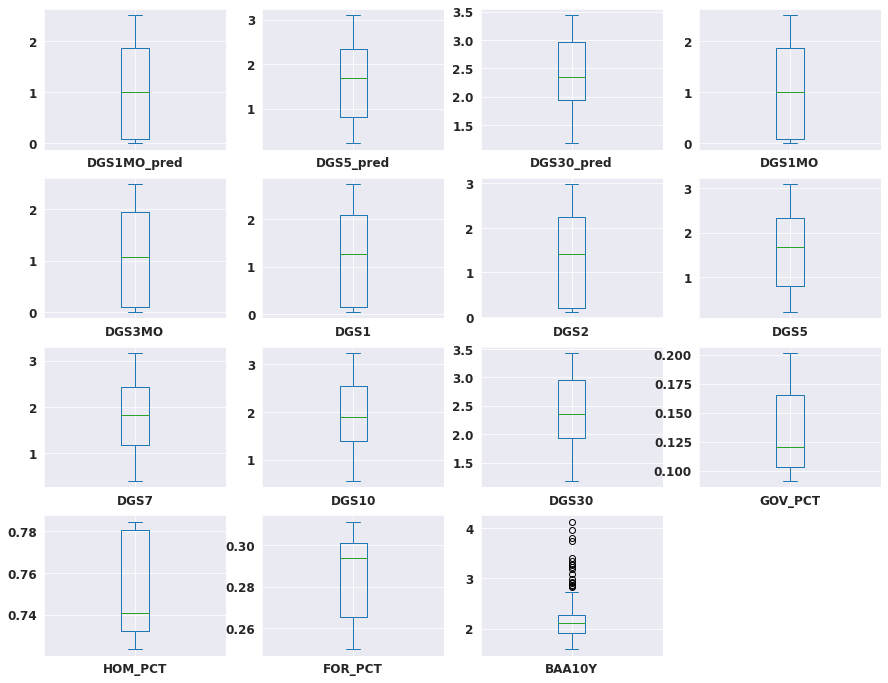

In [32]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()


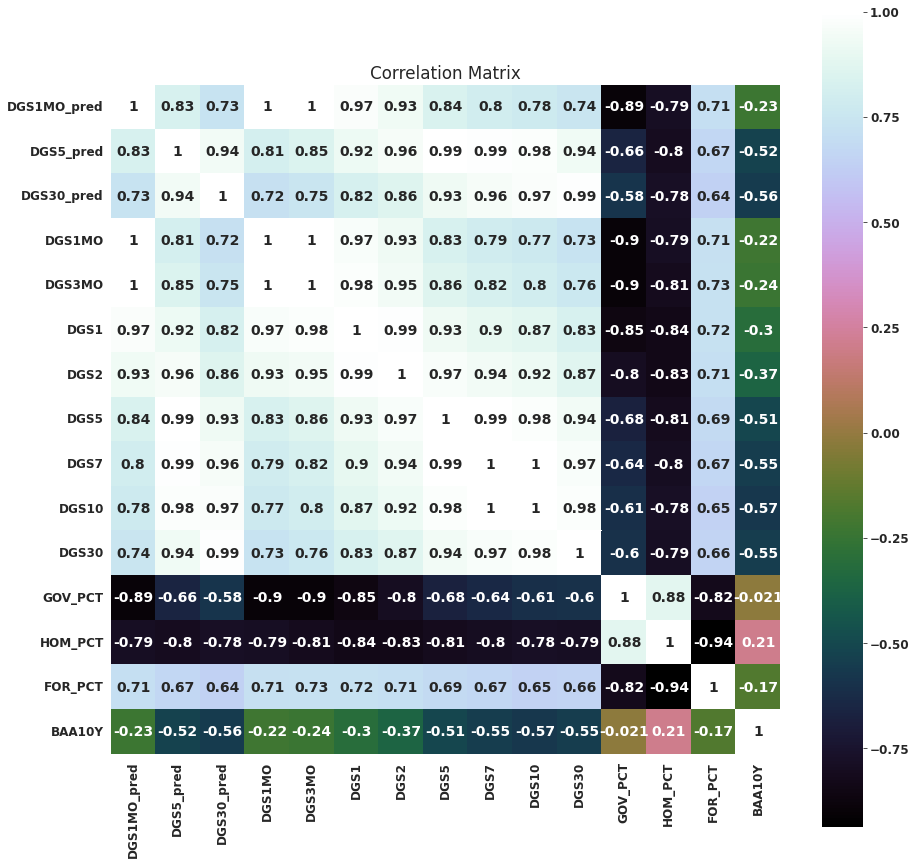

In [33]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

**Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.**

<Figure size 1080x1080 with 0 Axes>

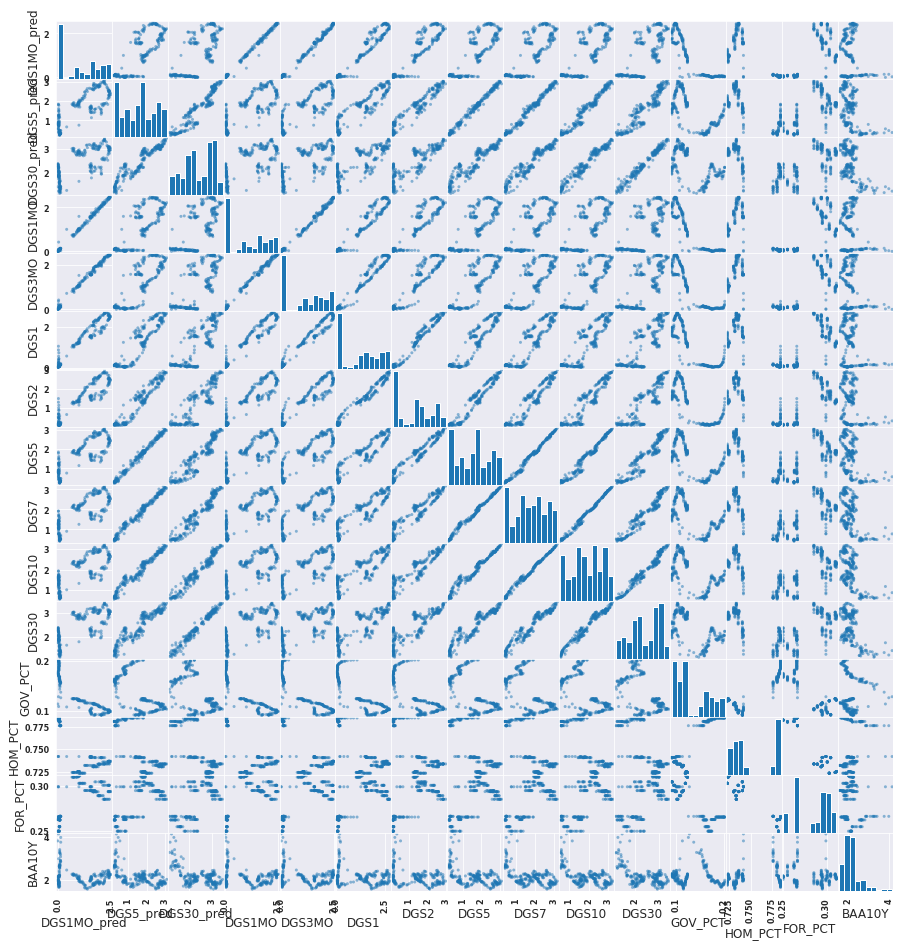

In [34]:


# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()



### **Time Series Analysis**

**1 Month**


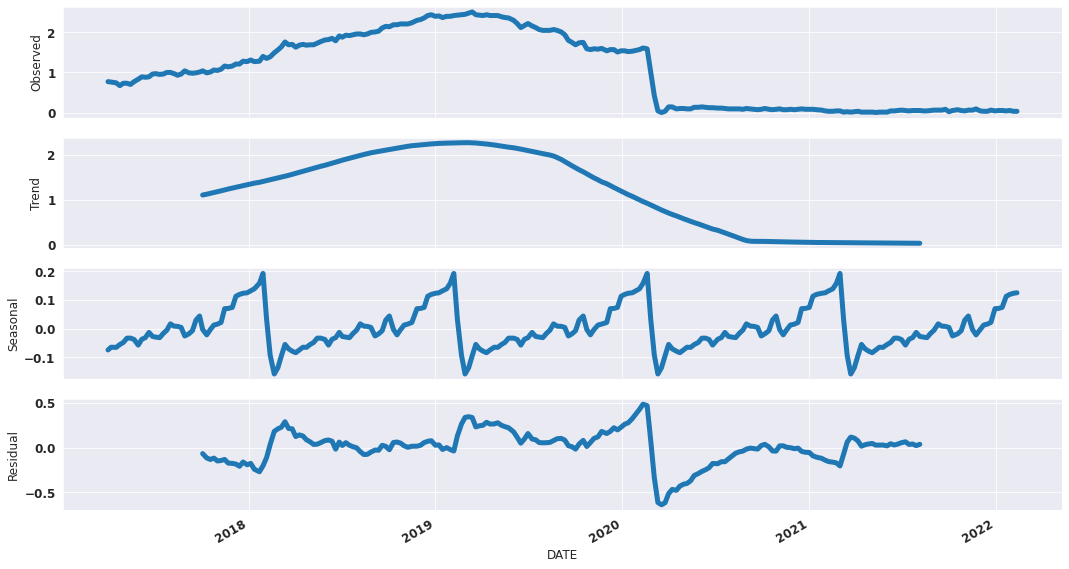

In [35]:

temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


**5 Year**


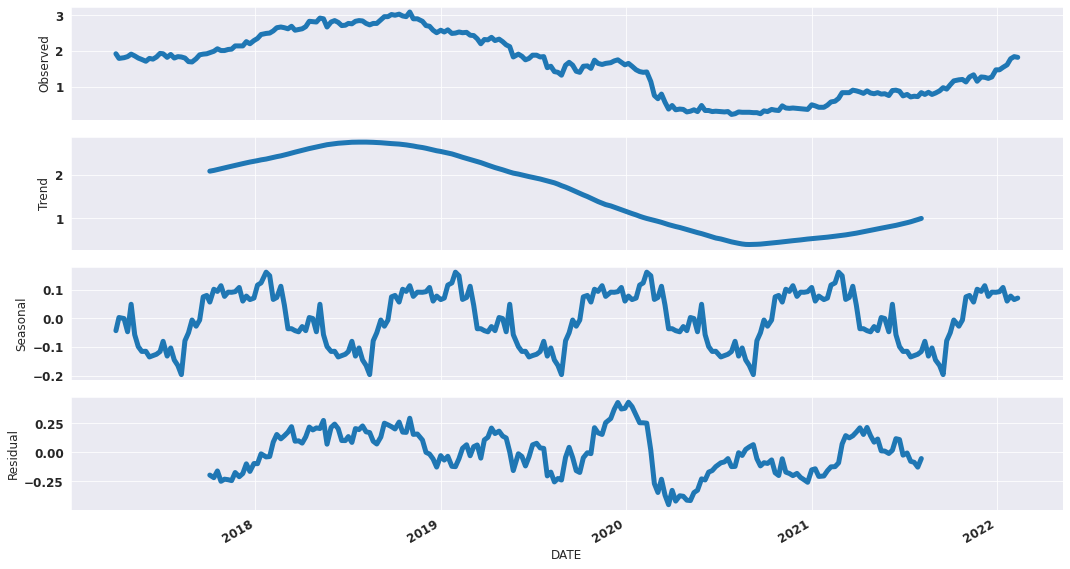

In [36]:

temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()




**30 Year**


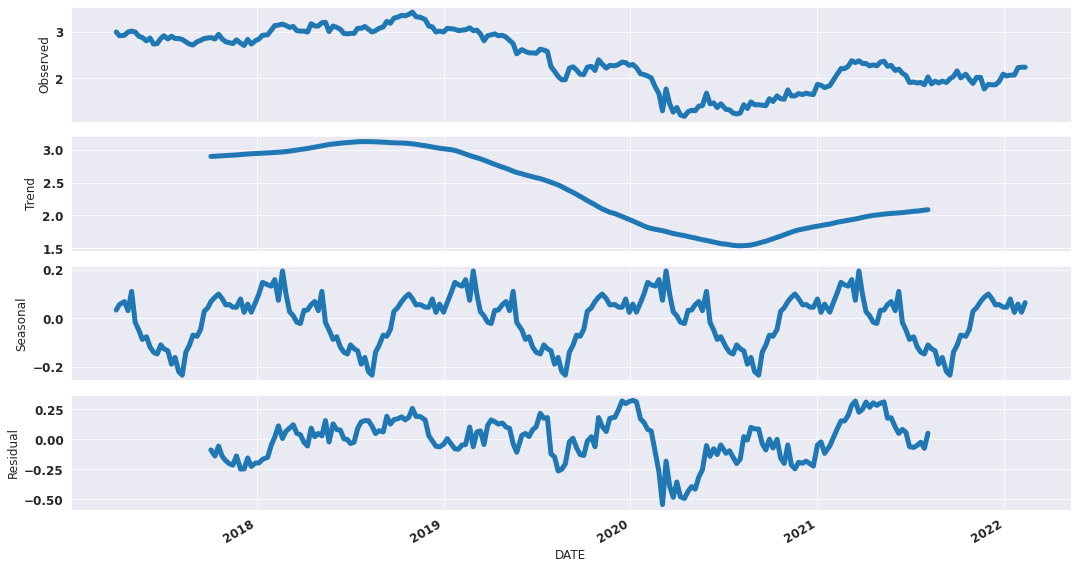

In [37]:

temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


## **Data Preparation and analysis**

**Univariate Feature Selection**

In [38]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')



DGS1MO_pred
     Specs      Score
0   DGS1MO  41233.342
1   DGS3MO  36412.988
2     DGS1   4176.412
3     DGS2   1621.761
8  GOV_PCT    954.919
4     DGS5    592.003
5     DGS7    443.256
9  HOM_PCT    412.656
6    DGS10    379.221
7    DGS30    303.442
--------------
DGS5_pred
      Specs      Score
4      DGS5  23742.911
5      DGS7  12348.495
6     DGS10   5397.662
3      DGS2   2921.096
7     DGS30   1709.335
2      DGS1   1349.823
1    DGS3MO    618.071
0    DGS1MO    483.913
9   HOM_PCT    438.135
10  FOR_PCT    201.502
--------------
DGS30_pred
      Specs     Score
7     DGS30  9473.243
6     DGS10  4446.214
5      DGS7  2613.607
4      DGS5  1606.246
3      DGS2   685.769
2      DGS1   507.300
9   HOM_PCT   381.375
1    DGS3MO   313.185
0    DGS1MO   256.610
10  FOR_PCT   169.707
--------------




**As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.**

## **Evaluate Algorithms and Models**

**Train Test Split and evaluation metrics**




In [40]:

# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'


# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.006462233847212386 
Std CV Error: (0.002491962140952718) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.006
DGS30_pred     0.008
dtype: float64 
Test Error:
DGS1MO_pred    0.011
DGS5_pred      0.010
DGS30_pred     0.010
dtype: float64
----------
LASSO: 
Average CV error: 0.6447999841248085 
Std CV Error: (0.08933890112791805) 
Training Error:
DGS1MO_pred    0.794
DGS5_pred      0.752
DGS30_pred     0.367
dtype: float64 
Test Error:
DGS1MO_pred    0.865
DGS5_pred      0.715
DGS30_pred     0.371
dtype: float64
----------
EN: 
Average CV error: 0.3844722616661713 
Std CV Error: (0.06604864623279481) 
Training Error:
DGS1MO_pred    0.369
DGS5_pred      0.398
DGS30_pred     0.367
dtype: float64 
Test Error:
DGS1MO_pred    0.411
DGS5_pred      0.377
DGS30_pred     0.371
dtype: float64
----------
KNN: 
Average CV error: 0.007448081052631577 
Std CV Error: (0.0035643019802905976) 
Training Error:
DGS1MO_pred    9.648e-04
DGS5_pred      5.372e-03
DGS30_pred     

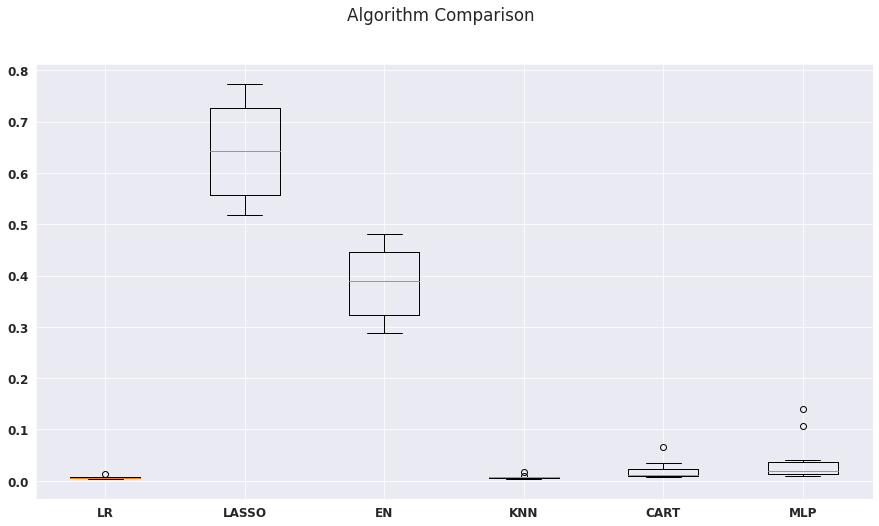

In [41]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

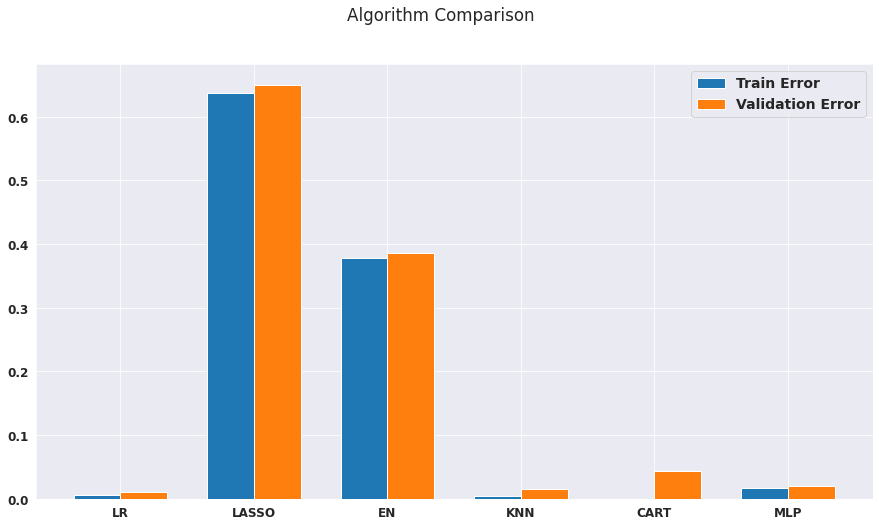

In [42]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()



## **Model Tuning and Grid Search**



In [44]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: -0.029917 using {'hidden_layer_sizes': (50,)}
-0.107379 (0.091287) with: {'hidden_layer_sizes': (20,)}
-0.029917 (0.030669) with: {'hidden_layer_sizes': (50,)}
-0.051487 (0.033893) with: {'hidden_layer_sizes': (20, 20)}
-0.043133 (0.050821) with: {'hidden_layer_sizes': (20, 30, 20)}


## **Finalise the Model**


In [45]:


# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)


MLPRegressor(hidden_layer_sizes=(20, 30, 20))

##  **Results and comparison of Regression and MLP**


In [46]:


# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))


MSE Regression = 0.010430, MSE MLP = 0.023226
R2 Regression = 0.981091, R2 MLP = 0.952972




The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set.

## **Predictions - 5 Year - MLP**


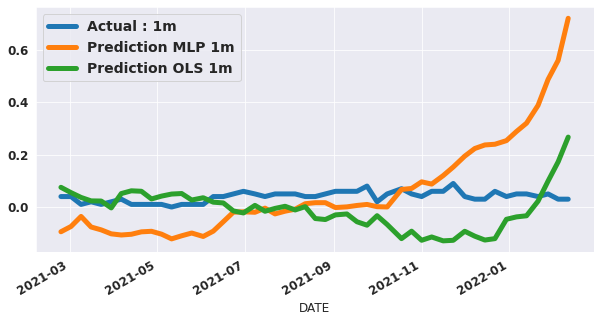

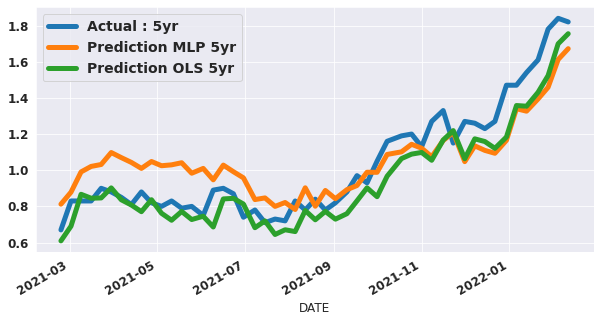

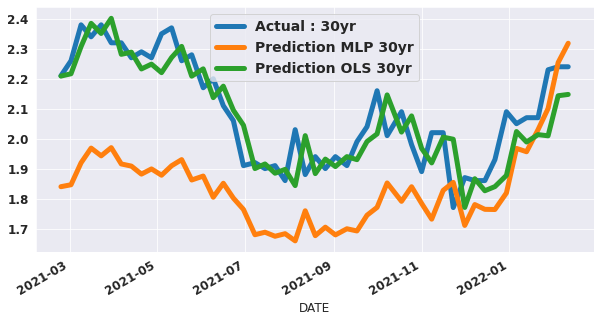

In [47]:


train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))


**Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl**

### **Summary**

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.
